(128, 256, 256) 10000.0


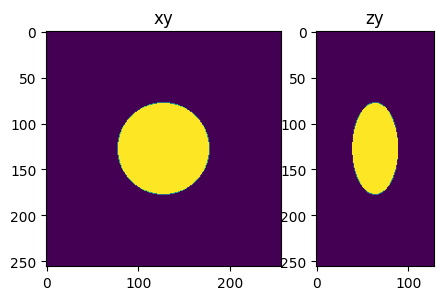

In [76]:
from skimage.io import imread
import os
from tnia.plotting.projections import show_xy_zy_max
path_=r"D:\images\tnia-python-images\deconvolution\bead_sim\single_bead"
fname = "sim_bead.tif"
truth = imread(os.path.join(path_,fname))

gain=10000

truth=truth*gain
fig=show_xy_zy_max(truth,figsize=(5,7))

print(truth.shape, truth.max())


sdeconv 1.x.x detected
0.9999999


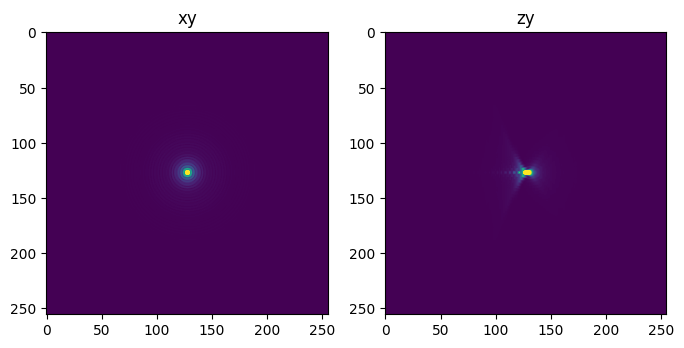

In [103]:
from tnia.nd.ndutil import centercrop
from tnia.deconvolution.psfs import gibson_lanni_3D
from tnia.plotting.projections import show_xy_zy_max
from tnia.deconvolution.psfs import recenter_psf_axial
from skimage.io import imsave

lowna=False

if lowna:
    ni=1
    ns  = 1.3
    NA=0.8
    w=0.530
    xy_spacing = .15
    z_spacing=.3
else:
    ni=1.515
    ns  = 1.45
    NA=1.4
    w=0.530
    xy_spacing = .08
    z_spacing=.16

z_ratio = xy_spacing/z_spacing

xy_psf_dim=256
z_compute_psf_dim=599
z_crop_psf_dim=256

#depth to compute PSF at
d=truth.shape[0]//2*z_spacing

psf  = gibson_lanni_3D(NA, ni, ns, xy_spacing, z_spacing, xy_psf_dim, z_compute_psf_dim, d, w)
psf = psf.astype('float32')

psf=recenter_psf_axial(psf, 255)
psf=psf/psf.sum()
fig=show_xy_zy_max(psf, vmax=psf.max()/4, figsize=(8,4))
print(psf.sum())

In [104]:
from tnia.nd.ndutil import centercrop

# list composition to crop psf by half
crop = [psf.shape[0], psf.shape[1]//2, psf.shape[2]//2]
psf = centercrop(psf, crop)

psf.shape


(255, 128, 128)

c:\users\bnort\work\imagej2022\tnia\tnia-python\tnia\deconvolution\forward.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  field = poisson(field_imaged.astype(float))


float32 (128, 256, 256) 0.0 2271.0
float32 (128, 256, 256) 0.0 10000.0


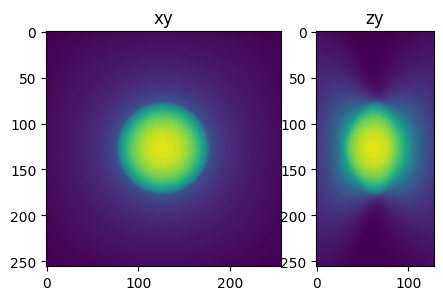

In [80]:
from tnia.deconvolution.forward import forward
image=forward(truth, psf, 10, add_poisson=True)
print(image.dtype, image.shape, image.min(), image.max())
print(truth.dtype, truth.shape, truth.min(), truth.max())
fig = show_xy_zy_max(image, figsize=(5,7))

In [88]:
from skimage.io import imsave

print(path_)
imsave(path_ + r"\beads_imaged.tif", image)

D:\images\tnia-python-images\deconvolution\bead_sim\single_bead


In [105]:
from clij2fft.richardson_lucy import richardson_lucy_nc

decons_low_na=decons

iterations = [80, 200, 500, 1000, 2000]
regs = [0.0, 0.0001]
decons=[]
titles=[]

decons.append(truth)
titles.append("truth")
decons.append(image)
titles.append("image")

for i in iterations:
    for r in regs: 
        print(i,r)
        decon = richardson_lucy_nc(image,psf,i,r)
        decons.append(decon)    
        titles.append("iterations: "+str(i)+" reg: "+str(r))
        imsave(path_ + r"\decon_"+str(i)+".tif", decon)


80 0.0
get lib
80 0.0001
get lib
200 0.0
get lib
200 0.0001
get lib
500 0.0
get lib
500 0.0001
get lib
1000 0.0
get lib
1000 0.0001
get lib
2000 0.0
get lib
2000 0.0001
get lib


1.0


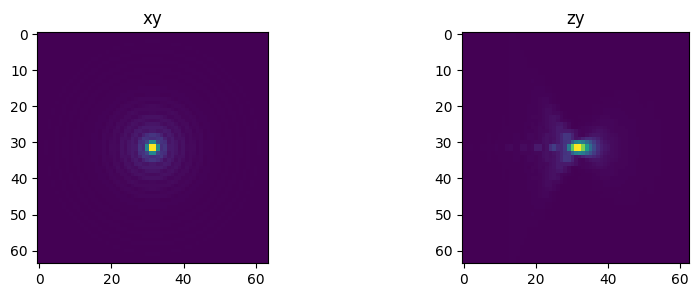

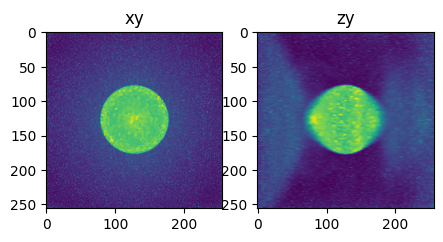

In [100]:
fig = show_xy_zy_max(psf)
fig = show_xy_zy_max(decons[-1], figsize=(5,7), sz=2)
psf=psf/psf.sum()
print(psf.sum())

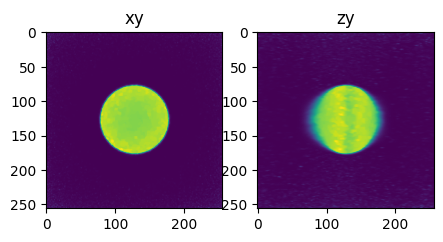

In [85]:
fig = show_xy_zy_max(decons[-1], figsize=(5,7), sz=2)

In [106]:
from skimage.filters import threshold_otsu
from skimage import measure
import pandas as pd
from tnia.metrics.errors import RMSE

#df=pd.DataFrame(columns=['title', 'mean_intensity', 'area', 'RMSE'])

for title, im in zip(titles, decons):

    

    thresholded= im>threshold_otsu(im)

    #fig = show_xy_zy_max(thresholded, figsize=(5,7))

    labels = measure.label(thresholded, connectivity=2)

    # Calculate properties of each object, such as the bounding box and intensity
    props = measure.regionprops_table(labels, im, properties=('mean_intensity', 'area'))

    df_temp=pd.DataFrame(props)
    df_temp=df_temp[df_temp['area']>100]
    
    # append RMSE
    rmse=RMSE(im, truth)
    df_temp['RMSE']=rmse
    df_temp['title']=title

    # append to df
    df=df.append(df_temp, ignore_index=True)

df

C:\Users\bnort\AppData\Local\Temp\ipykernel_26028\3239203584.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df_temp, ignore_index=True)
C:\Users\bnort\AppData\Local\Temp\ipykernel_26028\3239203584.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df_temp, ignore_index=True)
C:\Users\bnort\AppData\Local\Temp\ipykernel_26028\3239203584.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df_temp, ignore_index=True)
C:\Users\bnort\AppData\Local\Temp\ipykernel_26028\3239203584.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df_temp, ignore_index=True)
C:\Users\bnort\AppData\L

,title,mean_intensity,area,RMSE
0,truth,9999.999023,261992,0.000000
1,image,1670.681274,468134,1457.379272
2,iterations: 80 reg: 0.0,9342.199219,236796,562.043091
3,iterations: 80 reg: 0.0001,9348.252930,236480,561.884277
4,iterations: 200 reg: 0.0,9508.334961,243680,492.228790
...,...,...,...,...
67,iterations: 500 reg: 0.0001,6328.145996,237155,769.649048
68,iterations: 1000 reg: 0.0,6400.604980,239731,750.926208
69,iterations: 1000 reg: 0.0001,6397.532715,239787,747.391296
70,iterations: 2000 reg: 0.0,6489.594727,239953,746.605347


In [36]:
import napari
viewer = napari.Viewer()

viewer.add_image(im, name='im')
viewer.add_image(imaged, name='forward')
viewer.add_image(decons[0], name='decon '+str(iterations[0]))
viewer.add_image(decons[1], name='decon '+str(iterations[1]))
viewer.add_image(decons[2], name='decon '+str(iterations[2]))

<Image layer 'decon 5000' at 0x20814b67dc0>

In [35]:
from clij2fft.richardson_lucy import richardson_lucy_nc

iterations = [100, 1000, 5000]
regularization_factor = 0.0002
decons=[]

for i in iterations:
    decon = richardson_lucy_nc(imaged,psf,i,regularization_factor)
    decons.append(decon)    
    imsave(path_ + r"\decon_"+str(i)+".tif", decon)


get lib
get lib
get lib


In [37]:
from tnia.metrics.errors import RMSE
print(RMSE(im,imaged))
print(RMSE(im,decons[0]))
print(RMSE(im,decons[1]))
print(RMSE(im,decons[2]))

451.6636
234.62672
171.36023
148.5925


In [33]:
from tnia.metrics.errors import RMSE
print(RMSE(im,imaged))
print(RMSE(im,decons[0]))
print(RMSE(im,decons[1]))
print(RMSE(im,decons[2]))

451.6636
235.077
197.8101
308.51944


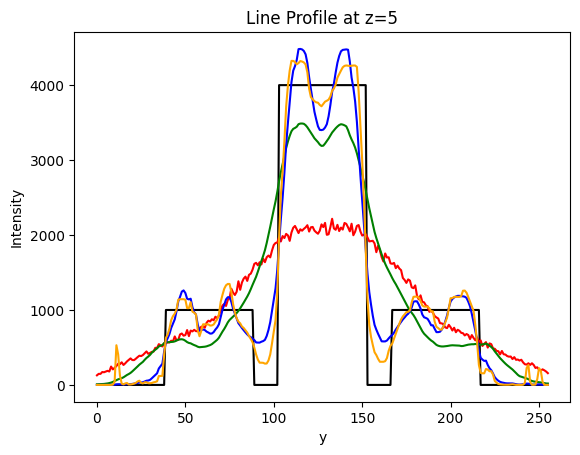

In [43]:
# generate line profiles
import numpy as np
import matplotlib.pyplot as plt


# Extract a line profile in the zy plane
z = 5  # Select a specific z-index
truth = im[:, 256, 128]
imaged = imaged[:, 256, 128]
decon_100 = decons[0][:, 256, 128]
decon_1000 = decons[1][:, 256, 128]
decon_5000 = decons[2][:, 256, 128]

# Plot the line profile using Matplotlib
fig, ax = plt.subplots()
ax.plot(truth, label='truth', color='black')
ax.plot(imaged, label='imaged', color='red')
ax.plot(decon_100, label='decon 100', color='green')
ax.plot(decon_1000, label='decon 1000', color='blue')
ax.plot(decon_5000, label='decon 5000', color='orange')

ax.set_xlabel('y')
ax.set_ylabel('Intensity')
ax.set_title(f'Line Profile at z={z}')
plt.show()


In [37]:
im.sum(), decon_100.sum(), forward.astype('float32').sum()

(4715858400.0, 4034974000.0, 3428855000.0)

In [25]:

decon_4000 = richardson_lucy_nc(forward,psf,4000)

get lib


In [26]:

from skimage.io import imsave

imsave(path_ + r"\decon_100.tif", decon_100)
imsave(path_ + r"\decon_500.tif", decon_500)
imsave(path_ + r"\decon_1000.tif", decon_1000)
imsave(path_ + r"\decon_4000.tif", decon_4000)

In [10]:
psf.dtype

dtype('float32')